## 生产者客户端的使用
生产者就是负责向 Kafka 发送消息的应用程序，一个正常的生产逻辑需要具备以下几个步骤：

1. 创建生产者实例
2. 发送消息
3. 关闭客户端

### 1. 创建生产者
通过设置参数，构建相应的生产者实例

In [1]:
from kafka import KafkaProducer
import json

In [2]:
KafkaProducer?

Init signature: KafkaProducer(**configs)
Docstring:     
A Kafka client that publishes records to the Kafka cluster.

The producer is thread safe and sharing a single producer instance across
threads will generally be faster than having multiple instances.

The producer consists of a pool of buffer space that holds records that
haven't yet been transmitted to the server as well as a background I/O
thread that is responsible for turning these records into requests and
transmitting them to the cluster.

:meth:`~kafka.KafkaProducer.send` is asynchronous. When called it adds the
record to a buffer of pending record sends and immediately returns. This
allows the producer to batch together individual records for efficiency.

The 'acks' config controls the criteria under which requests are considered
complete. The "all" setting will result in blocking on the full commit of
the record, the slowest but most durable setting.

If the request fails, the producer can automatically retry, unless
're

#### 关键参数
* bootstrap_servers 参数：指定生产者客户端连接 Kafka 集群所需的 broker 地址
* value_serializer 与 key_serializer 参数：broker 端接收的消息必须以字节数组（byte[]）的形式存在，如果创建生产者时配置了对应的erializer函数，生产者在发往 broker 之前会将消息中对应的 key 和 value 做相应的序列化操作来转换成字节数组
* retries 表明了生产者在发送消息时的重试次数

> KafkaProducer 是线程安全的，可以在多个线程中共享单个 KafkaProducer 实例

In [3]:
# 以构建json消息的生产者为例
producer = KafkaProducer(bootstrap_servers=["kafka1:9092"], value_serializer=lambda v: json.dumps(v).encode())

### 2. 发送消息
在创建完生产者实例之后，接下来的工作就是构建消息

In [4]:
producer.send?

Signature:
producer.send(
    topic,
    value=None,
    key=None,
    headers=None,
    partition=None,
    timestamp_ms=None,
)
Docstring:
Publish a message to a topic.

Arguments:
    topic (str): topic where the message will be published
    value (optional): message value. Must be type bytes, or be
        serializable to bytes via configured value_serializer. If value
        is None, key is required and message acts as a 'delete'.
        See kafka compaction documentation for more details:
        https://kafka.apache.org/documentation.html#compaction
        (compaction requires kafka >= 0.8.1)
    partition (int, optional): optionally specify a partition. If not
        set, the partition will be selected using the configured
        'partitioner'.
    key (optional): a key to associate with the message. Can be used to
        determine which partition to send the message to. If partition
        is None (and producer's partitioner config is left as default),
        then mes

In [13]:
# 发送一个带headers的json消息
message = "Hello, Kafka!"
headers = [("header_key1", b"header_value1"), ("header_key2", b"header_value2")]

future = producer.send('test_topic', value=message, headers=headers)

发送消息主要有三种模式：发后即忘（fire-and-forget）、同步（sync）及异步（async）。示例的使用方式就是第一种，发后即忘，不做任何处理。

这里的send()方法其实是一个异步的方法，返回异步操作的结果对象future，我们可以利用future的特性实现同步的发送方式


In [15]:
from kafka.errors import KafkaError
import logging

In [18]:
try:
    meta_data = future.get()
    print(f"{meta_data.topic} - {meta_data.partition} : {meta_data.offset}")
except KafkaError as excp:
    log.exception()

test_topic - 0 : 2


同步发送的方式可靠性高，要么消息被发送成功，要么发生异常。如果发生异常，则可以捕获并进行相应的处理，而不会像“发后即忘”的方式直接造成消息的丢失。不过同步发送的方式的性能会差很多，需要阻塞等待一条消息发送完之后才能发送下一条。

相较于同步方式，异步发送的方式性能要高很多，send() 方法的返回值类型就是 Future，本身就可以用作异步的逻辑处理，生产者的客户端提供Callback 的方式实现异步

In [20]:
# 异步方式发送消息
def on_send_success(record_metadata):
    print(record_metadata.topic)
    print(record_metadata.partition)
    print(record_metadata.offset)

def on_send_error(excp):
    log.error('I am an errback', exc_info=excp)
    # handle exception

producer.send('my-topic', 'raw_bytes').add_callback(on_send_success).add_errback(on_send_error)

# 堵塞进程，直到将缓存区中的消息全部发送
producer.flush()

my-topic
0
0


### 3. 关闭生产者

In [21]:
producer.close?

Signature: producer.close(timeout=None)
Docstring:
Close this producer.

Arguments:
    timeout (float, optional): timeout in seconds to wait for completion.
File:      /opt/conda/lib/python3.11/site-packages/kafka/producer/kafka.py
Type:      method

## 拦截器-序列化-分区器
生产者在通过 send() 方法将消息发往 broker 的过程中，需要发送的消息有可能需要经过拦截器（Interceptor）、序列化器（Serializer）和分区器（Partitioner）的一系列作用之后才能被真正地发往到 kafka 服务端

* 拦截器：在消息发送前做一些额外工作，比如按照某个规则过滤不符合要求的消息、修改消息的内容等
* 序列化：把消息的 key 与value 编码成字节数组
* 分区器：选择发送消息的主题分区

### 1. 拦截器

通过实现自定义的拦截器类并实现on_send()和on_ack()等方法来创建拦截器，定制拦截器的行为,可以在生产者创建时通过参数指定所要使用的拦截器

### 2. 序列化

生产者需要用序列化器（Serializer）把消息的key或者value转换成字节数组才能通过网络发送给 Kafka。而在对侧，消费者需要使用对应的反序列化器（Deserializer）才能把 Kafka 中收到的字节数组转换成相应的对象。可以在生产者创建时通过参数指定所要使用的序列化器

### 3. 分区器

消息经过序列化之后就需要确定它发往的分区，如果发送消息 send 方法中指定了 partition 字段，那么就不需要分区器的作用，直接发送到 partition 代表的分区。如果消息发送时中没有指定 partition 字段，那么就需要依赖生产者的分区器Partitioner，根据消息发送时的 key 字段来计算 partition 的分区，分区器的作用就是为消息分配分区

在默认分区器 DefaultPartitioner 的实现中，close() 是空方法，而在 partition() 方法中定义了主要的分区分配逻辑。如果 key 不为 null，那么默认的分区器会对 key 进行哈希（采用 MurmurHash2 算法，具备高运算性能及低碰撞率），最终根据得到的哈希值来计算分区号，拥有相同 key 的消息会被写入同一个分区。**如果 key 为 null，则采用Round Robin的方式将消息均匀地发送到所有可用分区**。

使用时，可以根据自身业务的需求来灵活实现分配分区的逻辑，可以在生产者创建时通过参数指定



## 生产者的原理解析
对 Kafka 生产者客户端的内部原理进行分析，通过了解生产者客户端的整体脉络可以让我们更好地使用它，避免因为一些理解上的偏差而造成使用上的错误

### 1. 整体架构

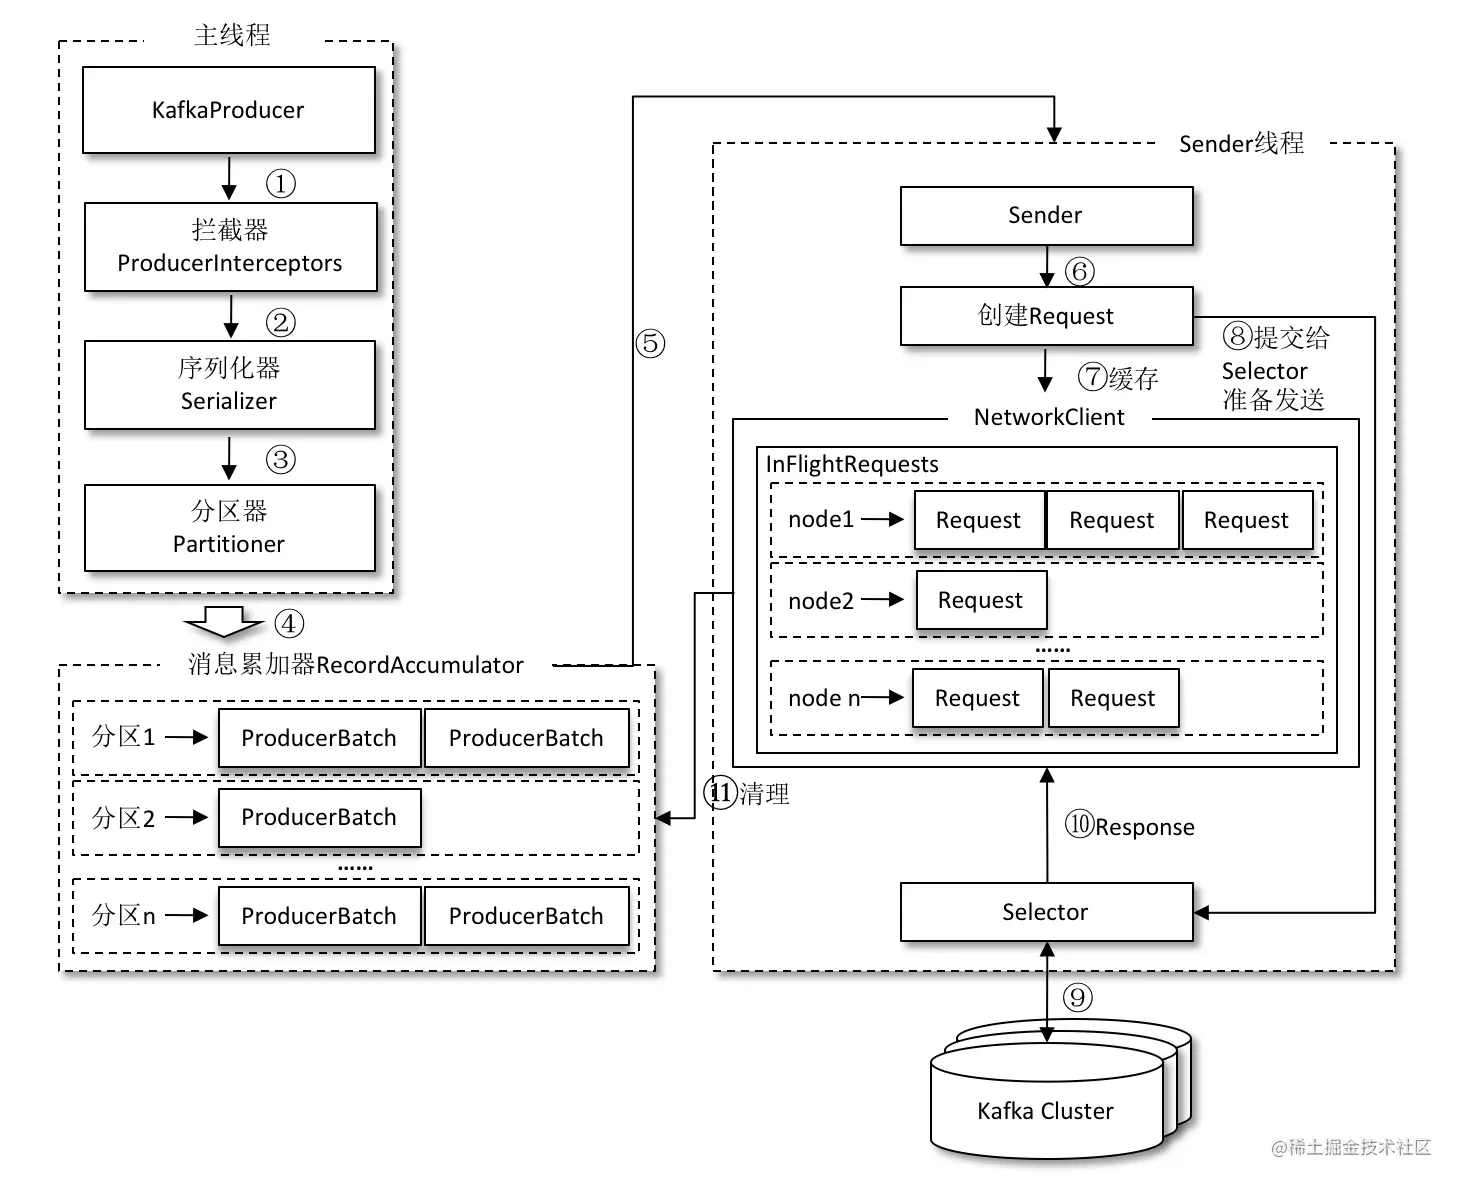
整个生产者客户端由两个线程协调运行，分别为主线程和 Sender 线程（发送线程）。在主线程中由 KafkaProducer 创建消息，然后通过可能的拦截器、序列化器和分区器的作用之后缓存到消息累加器（RecordAccumulator）中。Sender 线程负责从 RecordAccumulator 中获取消息并将其发送到 Kafka 中。

RecordAccumulator 缓存消息以便 Sender 线程可以批量发送，进而减少网络传输的资源消耗以提升性能。RecordAccumulator 缓存的大小可以通过生产者客户端参数 buffer.memory 配置，默认值为 33554432B，即32MB。生产者发送消息时，消息会首先被存储在缓冲区中，等待批量发送

主线程中发送过来的消息都会被追加到 RecordAccumulator 的某个双端队列（Deque）中，在 RecordAccumulator 的内部为每个分区都维护了一个双端队列，队列中的内容就是 ProducerBatch，当主线程发过来的消息总大小达到或超过batch.size时，会将这些消息打包成一个ProducerBatch，添加到队列尾端，sender进程不断从队列头部获取需要发送的批信息，进行批量发送

### 2. 元数据的更新

元数据的更新操作是在生产在者的客户端内部进行的，对外部使用者不可见。当生产者客户端需要更新元数据时，会先挑选出 leastLoadedNode，然后向这个 Node 发送 MetadataRequest 请求来获取具体的元数据信息。这个更新操作是由 Sender 线程发起的，在创建完 MetadataRequest 之后同样会存入 InFlightRequests，之后的步骤和发送消息时的类似。元数据由 Sender 线程负责更新，通过 synchronized 和 final 关键字同步到主线程